<a href="https://colab.research.google.com/github/hariansyahputra/Classification-Hijab-Use-Tensorflow-And-Implementation-Model-With-Augmented-Reality-in-Lens-Studio/blob/main/Evaluasi%20100%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import os
base_dir = '/content/drive/My Drive/Dataset Classification 100'

train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir, 'validation')

train_hijab_dir = os.path.join(train_dir, 'hijab')

train_nonhijab_dir = os.path.join(train_dir, 'nonhijab')

valid_hijab_dir = os.path.join(validation_dir, 'hijab')

valid_nonhijab_dir = os.path.join(validation_dir, 'nonhijab')

In [25]:
train_hijab_names = os.listdir(train_hijab_dir)
print(train_hijab_names[:10])

validation_hijab_names = os.listdir(valid_hijab_dir)
print(validation_hijab_names[:10])

train_nonhijab_names = os.listdir(train_nonhijab_dir)
print(train_nonhijab_names[:10])

['hijab.0014.jpg', 'hijab.0011.jpg', 'hijab.0016.jpg', 'hijab.0018.jpg', 'hijab.0002.jpg', 'hijab.0030.jpg', 'hijab.0015.jpg', 'hijab.0023.jpg', 'hijab.0029.jpg', 'hijab.0010.jpg']
['hijab.2009.jpg', 'hijab.2007.jpg', 'hijab.2001.jpg', 'hijab.2010.jpg', 'hijab.2002.jpg', 'hijab.2008.jpg', 'hijab.2003.jpg', 'hijab.2005.jpg', 'hijab.2004.jpg', 'hijab.2006.jpg']
['nonhijab.0011.jpg', 'nonhijab.0029.jpg', 'nonhijab.0004.jpg', 'nonhijab.0007.jpg', 'nonhijab.0026.jpg', 'nonhijab.0021.jpg', 'nonhijab.0025.jpg', 'nonhijab.0039.jpg', 'nonhijab.0001.jpg', 'nonhijab.0038.jpg']


In [26]:
print('train hijab images : ',len(os.listdir(train_hijab_dir)))
print('train nonhijab images:', len(os.listdir(train_nonhijab_dir)))
print('validation hijab images :', len(os.listdir(valid_hijab_dir)))
print('validation non hijab images :',len(os.listdir(valid_nonhijab_dir)))

train hijab images :  40
train nonhijab images: 40
validation hijab images : 10
validation non hijab images : 10


In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0



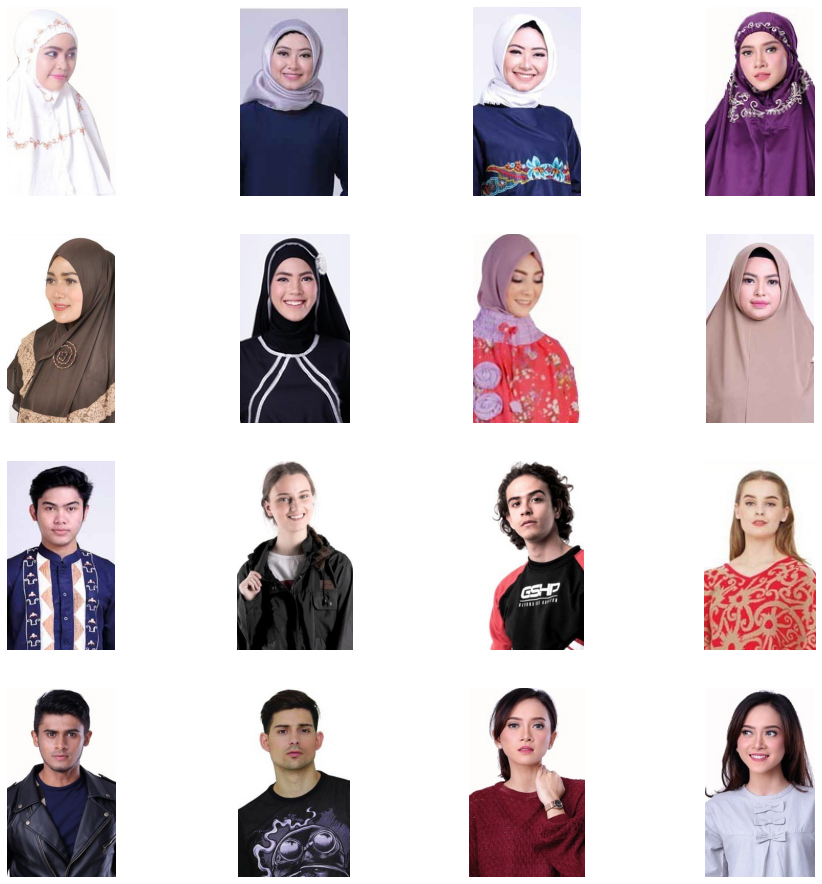

In [28]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches ( ncols*4, nrows*4)

pic_index += 8

next_hijab_pic = [os.path.join(train_hijab_dir,fname) 
for fname in train_hijab_names [pic_index -8 :pic_index]]
next_nonhijab_pic = [os.path.join(train_nonhijab_dir,fname)
for fname in train_nonhijab_names [pic_index-8 :pic_index]]

for i, img_path in enumerate(next_hijab_pic + next_nonhijab_pic):
    # Set up subplot; subplot indices start at 1

    sp = plt.subplot (nrows, ncols, i+1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 0.2,
                                   zoom_range =0.2,
                                   shear_range = 0.2,
                                   fill_mode = 'nearest',
                                   )

valid_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 0.2,
                                   zoom_range =0.2,
                                   shear_range = 0.2,
                                   fill_mode = 'nearest'
                                   )

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    batch_size = 4,
    class_mode = 'binary'
)

valid_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size = (150, 150),
    batch_size = 4,
    class_mode = 'binary'
)

Found 80 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


Building the CNN model

In [30]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve , auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

from scipy import interp

In [31]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x200 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 36, 36, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)       

In [33]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import TensorBoard

model.compile(loss= 'binary_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ["accuracy",tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [34]:
callbacks = TensorBoard(log_dir='./Graph')
history = model.fit(
    train_generator,
    steps_per_epoch =20 , # 80 images = batchsize * step/epoch ( 20*4)
    epochs = 10,
    verbose = 1,
    validation_data = valid_generator,
    validation_steps = 5,
    callbacks=[callbacks]
)

Epoch 1/10
20/20 [==============================] - 51s 2s/step - loss: 0.8869 - accuracy: 0.5125 - precision_1: 0.5128 - recall_1: 0.5000 - val_loss: 0.7271 - val_accuracy: 0.5000 - val_precision_1: 0.5000 - val_recall_1: 1.0000
Epoch 2/10
20/20 [==============================] - 8s 396ms/step - loss: 0.7197 - accuracy: 0.5750 - precision_1: 0.5500 - recall_1: 0.8250 - val_loss: 0.6691 - val_accuracy: 0.6500 - val_precision_1: 0.6000 - val_recall_1: 0.9000
Epoch 3/10
20/20 [==============================] - 8s 423ms/step - loss: 0.6442 - accuracy: 0.6750 - precision_1: 0.6842 - recall_1: 0.6500 - val_loss: 0.5703 - val_accuracy: 0.7500 - val_precision_1: 0.7273 - val_recall_1: 0.8000
Epoch 4/10
20/20 [==============================] - 9s 435ms/step - loss: 0.6419 - accuracy: 0.8250 - precision_1: 0.8611 - recall_1: 0.7750 - val_loss: 0.6259 - val_accuracy: 0.8000 - val_precision_1: 0.7500 - val_recall_1: 0.9000
Epoch 5/10
20/20 [==============================] - 8s 400ms/step - loss: 

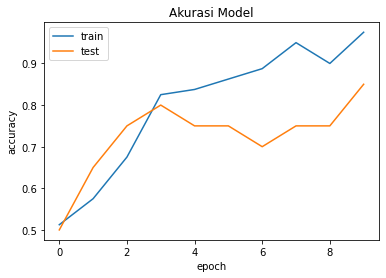

In [35]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

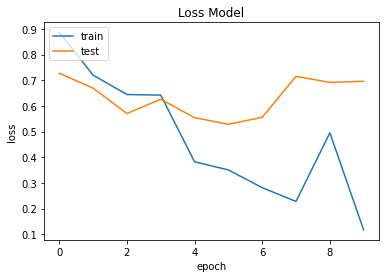

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

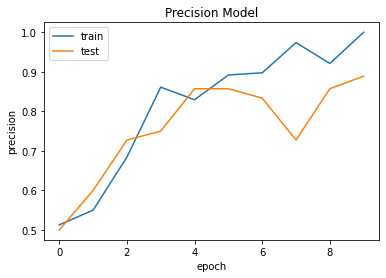

In [42]:
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.title('Precision Model')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

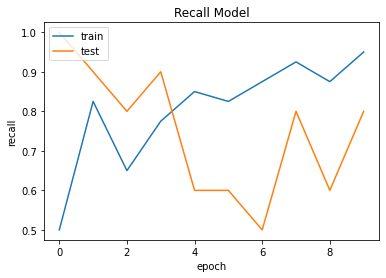

In [43]:
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('Recall Model')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
model.evaluate(valid_generator)

5/5 [==============================] - 0s 82ms/step - loss: 0.7999 - accuracy: 0.7000 - precision_1: 0.7500 - recall_1: 0.6000


[0.7999048233032227, 0.699999988079071, 0.75, 0.6000000238418579]

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

In [39]:
plt.plot(history_2.history_2['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('Recall Model')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Saving kecilin_hijab.jpeg to kecilin_hijab.jpeg


AttributeError: ignored